# Nye Fowler Solver (Python) v4.01

This Jupyter Notebook solves the Nye Fowler equations described by the associated Latex document (found here: https://www.overleaf.com/read/hzvvwvjkfwfj).

This version of the notebook solves the equations with the modifications made in section 4 (coupling with ice sheet model). V4.01 focuses on eliminating the lake from the equations and uses a coordinate system that scales with a varying grounding line


## Code:
First, we import the necessary libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_bvp
from IPython.display import clear_output
from matplotlib.colors import LogNorm


Next, we get our constants set up. These are mostly adjustable.

In [2]:
rho_w = 1000 # kg/m^3 (water density)
rho_i = 900 #kg/m^3 (ice density)
g = 10 # m/s^2 (gravitational acceleration)
L = 3.3*10**5 # J/kg
K0 = 10**-24 # Pa^-3 s^-2
phi_s = 0.01 # surface slope
psi_0 = rho_w*g*phi_s 
n_prime = 0.1 # m^-1/3 s (hydraulic roughness)
f = 6.6*n_prime**2 
s_to_y = 60*60*24*365.25 

tau_raw = 4455 # Pa - changed so HD is around 100m with h at s=10km to be 90m
h_end = 10 # m

# Scales
s0 = 10*10**3 # m
Q0 = 1500 # m^3/s
m0 = Q0*psi_0/L 
S0 = (f*rho_w*g*Q0**2/psi_0)**(3/8)
N0 = (K0*rho_i*S0*L/(psi_0*Q0))**(-1/3)
t0 = rho_i*S0*L/(psi_0*Q0)
M0 = Q0/s0
HD = np.sqrt(h_end**2 + 2*tau_raw*s0/(rho_i*g)) 
#h0 = rho_i*HD/rho_w

# Model Params
eps = s0*m0/(Q0*rho_i)
r = rho_i/rho_w
delta = N0/(s0*psi_0)
#beta_r = rho_w*g*h0/N0

# Inputs
Q_in = 10/Q0
#hL_pl1 = 1
#VL = 0.5*1000000 # m^3
tau = tau_raw/N0
C = 2*10**-20 # For sliding law https://onlinelibrary.wiley.com/doi/10.1002/hyp.7029
alpha = C*(N0**3)*t0/s0 # For sliding law

#lda = t0*Q0/(10*VL*h0)
psi = 1
M = 5*10**-4/M0

# Hack for capping velocity at terminus
umax = 1000/(s0*s_to_y/t0);
gamma = alpha*(tau**4)/umax

# Details for storage of variables, user specified
grid_space = 100 
time_space = 2000
del_t = 0.05 

# Storage arrays
sigma = np.linspace(0,1,grid_space) # position coordinate normalized to sigma
#h = np.zeros(time_space)
S = np.zeros((time_space,grid_space))
Q = np.zeros((time_space,grid_space))
N = np.zeros((time_space,grid_space))
u = np.zeros((time_space,grid_space))

# Store different grounding line positions
x_g = np.zeros(time_space)
x_g[0] = 1; # Normalize grounding line by s0

# Initial conditions
S[0,:] = 5*np.ones(grid_space)/S0

# Defining psi as a function of sigma (ie assuming H is a function of sigma)
# These h, tau, and psi assumptions will be fixed when an actual ice sheet model is incorporated
psi_var = (rho_w*g*phi_s + tau_raw/np.sqrt(HD**2 - 2*tau_raw*sigma*s0/(rho_i*g)))/psi_0

# Boundary conditions
#NL = beta_r*(1-h[0])
QL = Q_in
Nt = 0 # glacier ends


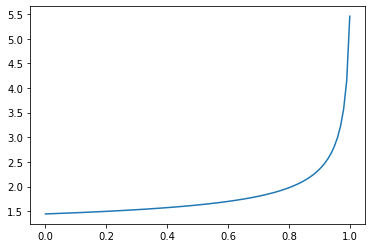

In [3]:
plt.plot(sigma,psi_var)

Now, we set up the functions that the solver uses. This first one defines the coupled differential equations for Q and N

In [4]:
def Nye_NQ(x,y):
    S_i_var = np.interp(x,np.linspace(0,1,grid_space),S_i)
    S83 = S_i_var**(8/3)
    Q = y[1]
    N = y[0]
    psi_var_interp = np.interp(x,np.linspace(0,1,grid_space),psi_var)
    # solve d/dsigma
    return np.vstack(((Q*np.abs(Q)/S83 - psi_var_interp)*x_gi/delta, 
                      x_gi*(eps*(r-1)*np.abs(Q)**3/S83 + eps*S_i_var*N**3 + M)))

This function defines the boundary conditions

In [5]:
def bc_N(ya,yb):
    return np.array([ya[1]-QL, yb[0]-Nt])

This code snippet solves the system of differential equations. It takes a while to run, and an output appears below the box (though it looks erratic, it paints a sense of if the code is running properly and how long it has been running for

In [6]:
%%time
# initial guess
y = np.zeros((2, sigma.size))
x = sigma # because we need x,y format for the solver
y[0,:]= np.sin(sigma*np.pi)
y[1,:]= 0.001 + M*sigma# solve initial step
S_i = S[0,:]
x_gi = x_g[0]
sol = solve_bvp(Nye_NQ, bc_N,x,y,verbose=2)
N[0,:]=np.interp(sigma,sol.x,sol.y[0])
Q[0,:]=np.interp(sigma,sol.x,sol.y[1])
u[0,:]=alpha*(tau**4)/(N[0,:]+gamma)
dSdsigma = np.gradient(S_i)/np.gradient(sigma)
S[1,:] = S_i + del_t*(np.abs(Q[0,:])**3/S_i**(8/3) - S_i*N[0,:]**3 - u[0,:]*dSdsigma/x_gi + (sigma/x_gi)*u[0,-1]*dSdsigma)
#h[1] = h[0] + del_t*lda*(Q_in-Q[0,0])/hL_pl1;
#NL = beta_r*(1-h[1])

# Evolve grounding line
x_g[1] = x_g[0] + del_t*u[0,-1] # non dimensionalized


# Now we loop
for i in range(1,time_space-1):
    print(i)
    clear_output(wait=True)
    sigma = np.linspace(0,1,grid_space)
    y = np.zeros((2, sigma.size))
    x = sigma
    y[0,:]= N[i-1,:]
    y[1,:]= Q[i-1,:]
    S_i = S[i,:]
    x_gi = x_g[i]
    # Right now assuming psi just scales with sigma
    sol = solve_bvp(Nye_NQ, bc_N,x,y,tol=0.00000001,bc_tol=0.00000001,verbose=2,max_nodes=10000)
    if sol.status == 2:
        break
    N[i,:]=np.interp(sigma,sol.x,sol.y[0])
    Q[i,:]=np.interp(sigma,sol.x,sol.y[1])
    u[i,:]=alpha*(tau**4)/(N[i,:]+gamma)
    dSdsigma = np.gradient(S_i)/np.gradient(sigma)
    S[i+1,:] = S_i + del_t*(np.abs(Q[i,:])**3/S_i**(8/3) - S_i*N[i,:]**3 - u[i,:]*dSdsigma/x_gi + (x/x_gi)*u[i,-1]*dSdsigma)
    #h[i+1] = h[i] + del_t*lda*(Q_in-Q[i,0])/hL_pl1
    #if (h[i+1]<=0) or (S[i+1,:].any()<=0):
    #    break
    #NL = beta_r*(1-h[i])
    x_g[i+1] = x_g[i] + del_t*u[i,-1]

   Iteration    Max residual  Max BC residual  Total nodes    Nodes added  
       1          4.76e-05       0.00e+00          100            64       
       2          2.30e-06       0.00e+00          164            95       
       3          1.24e-07       0.00e+00          259            95       
       4          1.59e-08       0.00e+00          354            18       
       5          9.89e-09       0.00e+00          372             0       
Solved in 5 iterations, number of nodes 372. 
Maximum relative residual: 9.89e-09 
Maximum boundary residual: 0.00e+00
CPU times: user 47.8 s, sys: 6.39 s, total: 54.2 s
Wall time: 46.2 s


Now, the output from above is converted into values with units for our plots. At some point it could be wise to export these values into a csv to save the data

In [7]:
time_years = t0*del_t*np.arange(time_space)/s_to_y
#h_meters = h0*h
Q_m3ps = Q0*Q
S_m2 = S0*S
N_Pa = N0*N
u_mpy = u*s0*s_to_y/t0
xg_km = s0*x_g/1000


Now, the plots for lake depth, channel flow rate (at entrance and exit), and channel surface area (at entrance and exit) are made.

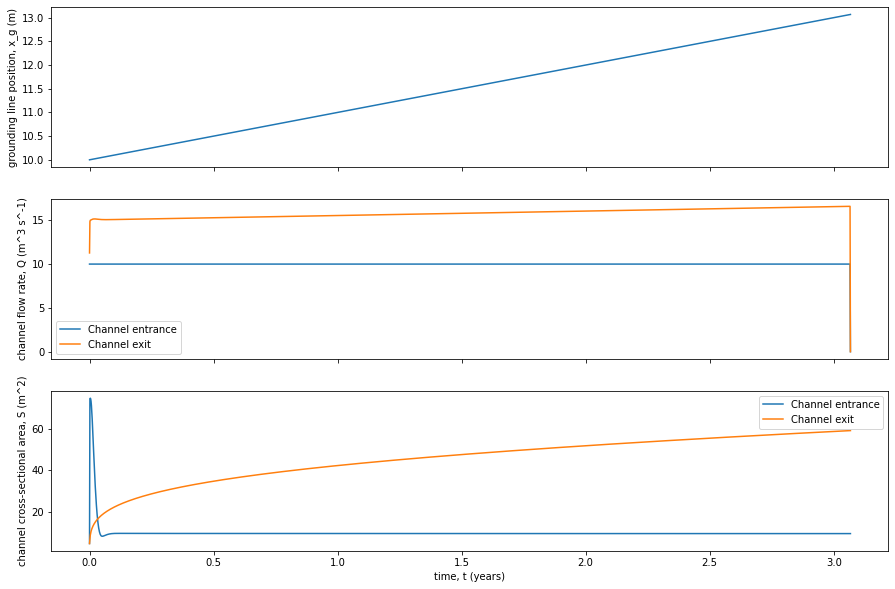

In [8]:
fig, ax = plt.subplots(3,figsize=[15,10],sharex=True)
ax[0].plot(time_years,xg_km)
ax[0].set_ylabel('grounding line position, x_g (m)')

ax[1].plot(time_years,Q_m3ps[:,0],label='Channel entrance')
ax[1].plot(time_years,Q_m3ps[:,-1],label='Channel exit')
ax[1].set_ylabel('channel flow rate, Q (m^3 s^-1)')
ax[1].legend()

ax[2].plot(time_years,S_m2[:,0],label='Channel entrance')
ax[2].plot(time_years,S_m2[:,-1],label='Channel exit')
ax[2].set_ylabel('channel cross-sectional area, S (m^2)')
ax[2].set_xlabel('time, t (years)')
ax[2].legend()


The following plots are colormaps of the effective pressure, channel flow rate, cross sectional area, and glacier basal velocity. 

/tmp/ipykernel_552/3169204733.py:18: UserWarning: Log scale: values of z <= 0 have been masked
  p3 = ax[3].contourf(time_years,sigma[0:-1],u_mpy.transpose()[0:-1,:],norm=LogNorm())


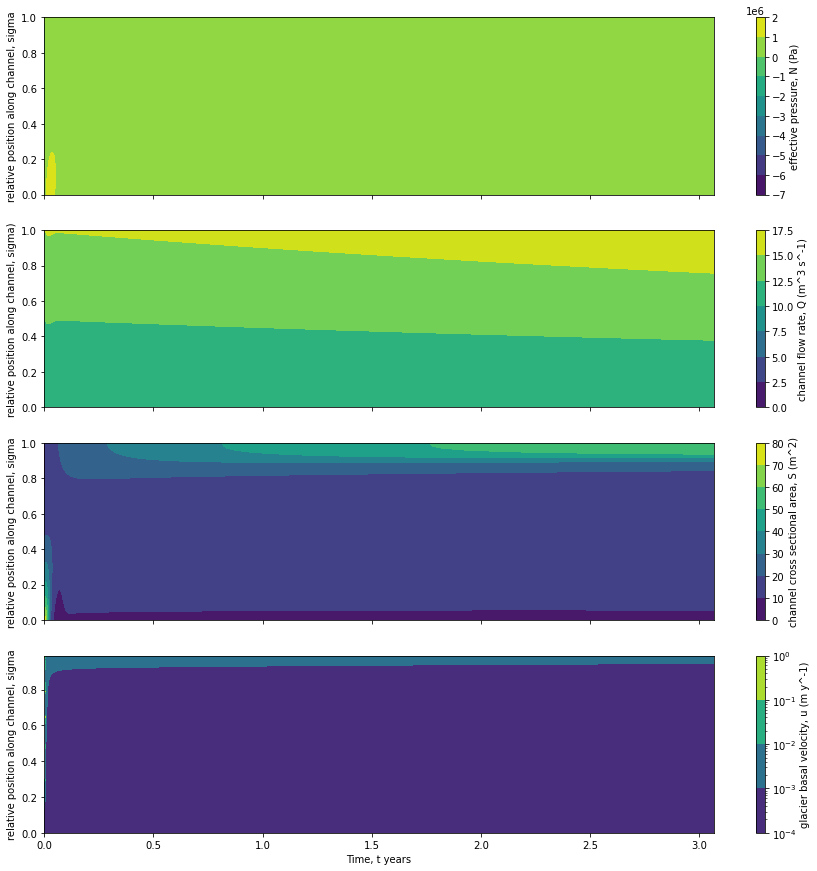

In [9]:
fig, ax = plt.subplots(4,figsize=[15,15],sharex=True)
#plt.xlim([0,3])
p0 = ax[0].contourf(time_years,sigma,N_Pa.transpose())
ax[0].set_ylabel('relative position along channel, sigma')
cbar0 = fig.colorbar(p0,ax=ax[0])
cbar0.set_label('effective pressure, N (Pa)')

p1 = ax[1].contourf(time_years,sigma,Q_m3ps.transpose())
ax[1].set_ylabel('relative position along channel, sigma)')
cbar1 = fig.colorbar(p1,ax=ax[1])
cbar1.set_label('channel flow rate, Q (m^3 s^-1)')

p2 = ax[2].contourf(time_years,sigma,S_m2.transpose())
ax[2].set_ylabel('relative position along channel, sigma')
cbar2 = fig.colorbar(p2,ax=ax[2])
cbar2.set_label('channel cross sectional area, S (m^2)')

p3 = ax[3].contourf(time_years,sigma[0:-1],u_mpy.transpose()[0:-1,:],norm=LogNorm())
ax[3].set_ylabel('relative position along channel, sigma')
ax[3].set_xlabel('Time, t years')
cbar3 = fig.colorbar(p3,ax=ax[3])
cbar3.set_label('glacier basal velocity, u (m y^-1)')

Plotting in terms of x rather than sigma

In [10]:
sigma_grid = np.transpose([sigma] * time_space)
x_km = sigma_grid*xg_km
time_grid = np.tile(time_years, (grid_space, 1))


/tmp/ipykernel_552/3881474802.py:18: UserWarning: Log scale: values of z <= 0 have been masked
  p3 = ax[3].contourf(time_grid[0:-1,:],x_km[0:-1,:],u_mpy.transpose()[0:-1,:],norm=LogNorm())


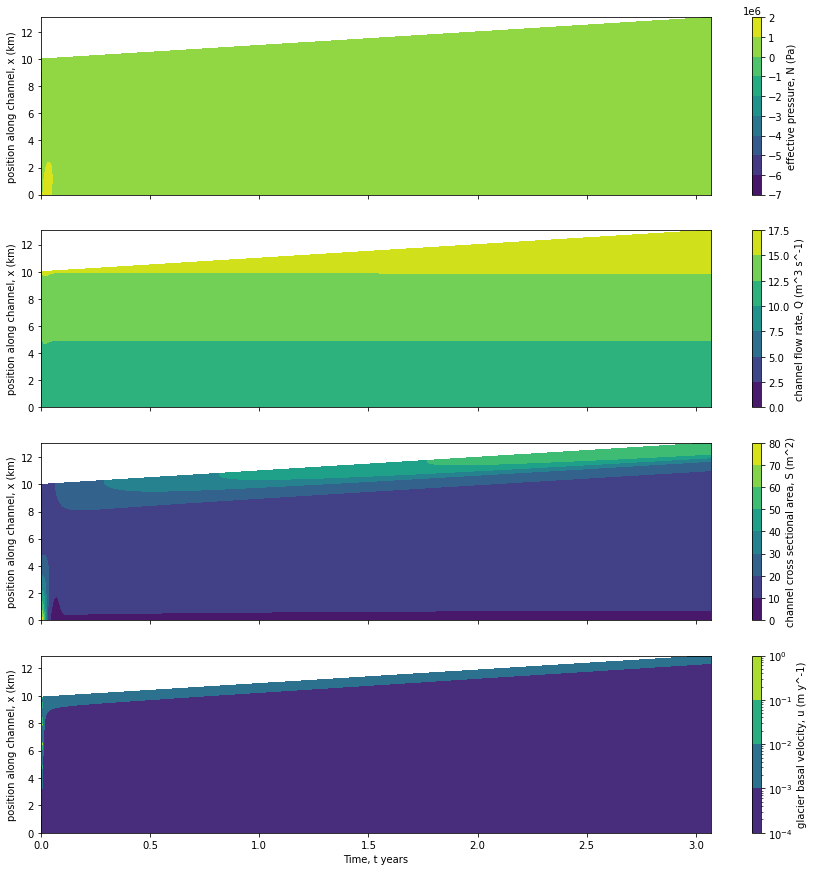

In [11]:
fig, ax = plt.subplots(4,figsize=[15,15],sharex=True)
#plt.xlim([0,3])
p0 = ax[0].contourf(time_grid,x_km,N_Pa.transpose())
ax[0].set_ylabel('position along channel, x (km)')
cbar0 = fig.colorbar(p0,ax=ax[0])
cbar0.set_label('effective pressure, N (Pa)')

p1 = ax[1].contourf(time_grid,x_km,Q_m3ps.transpose())
ax[1].set_ylabel('position along channel, x (km)')
cbar1 = fig.colorbar(p1,ax=ax[1])
cbar1.set_label('channel flow rate, Q (m^3 s^-1)')

p2 = ax[2].contourf(time_grid,x_km,S_m2.transpose())
ax[2].set_ylabel('position along channel, x (km)')
cbar2 = fig.colorbar(p2,ax=ax[2])
cbar2.set_label('channel cross sectional area, S (m^2)')

p3 = ax[3].contourf(time_grid[0:-1,:],x_km[0:-1,:],u_mpy.transpose()[0:-1,:],norm=LogNorm())
ax[3].set_ylabel('position along channel, x (km)')
ax[3].set_xlabel('Time, t years')
cbar3 = fig.colorbar(p3,ax=ax[3])
cbar3.set_label('glacier basal velocity, u (m y^-1)')